In [1]:
seed = 0

In [2]:
from utilities.load_data import load_fullECAI
from utilities.evaluation import *
from utilities.evaluation import _my_scorer

In [3]:
import os
import joblib

import numpy as np
import pandas as pd
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, Normalizer

import shap

C:\Users\azael\miniconda3\envs\ciencia_datos_nogpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset = load_fullECAI()
# Prep data
X = dataset.drop('status', axis=1)
y = dataset.loc[:, 'status']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, stratify=y)

In [5]:
grid_name = 'GridSearchCV_22-03-22_03-27-03'
grid = joblib.load('./results/XGBoost/{}/{}.pkl'.format(grid_name, grid_name))

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [6]:
model = grid.best_estimator_

In [7]:
explainer = shap.Explainer(model)
shap_test = explainer(X_test)
shap_df = pd.DataFrame(shap_test.values, 
                       columns=shap_test.feature_names, 
                       index=X_test.index)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


## Graph representation

In [8]:
from igraph import Graph
import igraph as ig
from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
%%time
shap_dist = euclidean_distances(shap_df)
# Scale distances 0 - 1
#normalized_dist = MinMaxScaler().fit_transform(shap_dist)
#n = normalized_dist.shape[0]

CPU times: total: 484 ms
Wall time: 134 ms


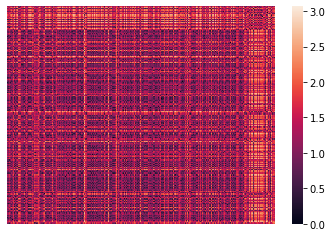

In [15]:
ax = sns.heatmap(shap_dist[np.argsort(y_test).values][:,np.argsort(y_test).values], xticklabels=False, yticklabels=False)
ax.invert_yaxis()
if not os.path.exists('./results/XGBoost/{}/figures/Best'.format(grid_name)):
    os.makedirs('./results/XGBoost/{}/figures/Best'.format(grid_name))
plt.savefig('./results/XGBoost/{}/figures/Best/adjmatrix.png'.format(grid_name), bbox_inches='tight', dpi=300, transparent=True)

In [10]:
shap_df, _, y_test1, _= train_test_split(shap_df, y_test, train_size=.3)
shap_dist = euclidean_distances(shap_df)

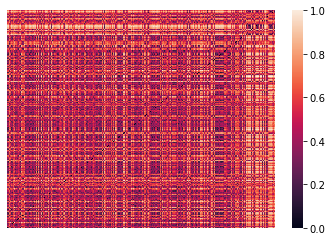

In [11]:
normalized_dist = MinMaxScaler().fit_transform(shap_dist)
ax = sns.heatmap(normalized_dist[np.argsort(y_test1).values][:,np.argsort(y_test1).values], xticklabels=False, yticklabels=False)
ax.invert_yaxis()

# Reduce Dimension

## Criteria: Efficiency

In [39]:
%%time
def nodal_eff(g):
    """
    Finds local nodal efficiency
    
    Source: https://stackoverflow.com/questions/56609704/how-do-i-calculate-the-global-efficiency-of-graph-in-igraph-python
    
    Parameters
    --------
    g : igraph.Graph
        Weighted Graph
    
    Returns
    --------
    ne : float
        Nodal efficiency
    
    Examples
    --------
    # Local efficiency
    >>> eff = nodal_eff(g)
    # Global efficiency
    >>> global_eff = mean(eff)
    """

    
    weights = g.es["weight"][:]
    sp = (1.0 / np.array(g.shortest_paths_dijkstra(weights=weights)))
    np.fill_diagonal(sp,0)
    N=sp.shape[0]
    ne= (1.0/(N-1)) * np.apply_along_axis(sum,0,sp)

    return ne

# Local
#eff = nodal_eff(fullg)
# Global
#np.mean(eff)

CPU times: total: 0 ns
Wall time: 0 ns


In [30]:
%%time

cutoffs = np.array(range(1,11))/10
effs = []
for co in cutoffs:
    # Remove edges between too far vertices
    adj_matrix = normalized_dist.copy()
    too_far = adj_matrix > co
    adj_matrix = adj_matrix.astype(object) 
    adj_matrix[too_far] = None
    
    reduced_G = Graph.Weighted_Adjacency(adj_matrix, mode='undirected', loops=False)
    eff = nodal_eff(reduced_G)
    effs.append(np.mean(eff))

divide by zero encountered in true_divide


CPU times: total: 43.7 s
Wall time: 43.9 s


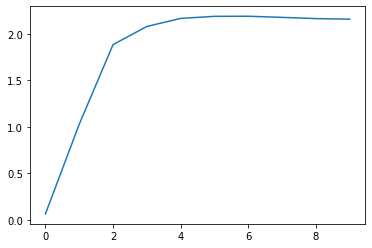

In [37]:
plt.plot(effs)